# Challenge Description

Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.


Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

You are asked to:

1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better


2. Explain why that might be happening. Are the localized translations really worse?


3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from pyecharts.charts import Bar,Pie,Grid,Line
from pyecharts import options as opts
import pyecharts

In [6]:
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [7]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [8]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [11]:
(test.shape, user.shape)

((453321, 9), (452867, 4))

In [9]:
total = test.merge(user, on='user_id', how='left')

In [10]:
total.shape

(453321, 12)

In [13]:
total.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

In [14]:
271444/test.shape[0]

0.5987898200171622

- there are 454 records that we don't have the user information: we should discard those records
- there are also 60% missing ads channel information

In [15]:
total = test.merge(user, on='user_id', how='inner')

In [16]:
total.shape

(452867, 12)

In [18]:
total.duplicated().any()

False

In [19]:
total.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64

In [20]:
total.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


# Data Quality Check 

## Pre-experiment

In [236]:
n_control = total.loc[total['test']==0].shape[0]
n_test = total.loc[total['test']==1].shape[0]
n_test/(n_control+n_test)

0.4764621842616044

- ### Country

In [69]:
grouped_control = total.loc[total['test']==0].groupby('country')['test'].count().reset_index()
grouped_test = total.loc[total['test']==1].groupby('country')['test'].count().reset_index()

- Note that Spain is always assigned to the control group, since there is no difference for that country

In [70]:
df = pd.DataFrame(np.array([['Spain', 0]]))
df.columns = ['country', 'test']
grouped_test = grouped_test.append(df).reset_index(drop=True).sort_values(by='country')

In [122]:
attr = grouped_control['country'].to_list()
v1 = grouped_control['test'].to_list()
v2 = grouped_test['test'].to_list()
bar2 = (Bar().add_xaxis(attr)
        .add_yaxis("Control Group",v1, category_gap="30%", color='#619999',
                   markpoint_opts=opts.MarkPointOpts(
                     data=[opts.MarkPointItem(name="Argentina", coord=[attr[0], v1[0]], value=v1[0]),
                     opts.MarkPointItem(name="Urug", coord=[attr[15], v1[15]], value=v1[15])]))
        .add_yaxis("Test Group",v2, category_gap="30%", color='#c26767',
                   markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="min")]))
        .set_global_opts(title_opts=opts.TitleOpts(title="Assignment by Country"),
                         #datazoom_opts=opts.DataZoomOpts(),
                        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-90)))
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
       )
bar2.render_notebook()

In [149]:
country = total.groupby(['country'])['test'].mean().reset_index()
attr = country['country'].to_list()
v1 = country['test'].to_list()
bar2 = (Bar().add_xaxis(attr)
        .add_yaxis("Control Group",v1, category_gap="30%",color='#ba4c4d')    
        .set_global_opts(title_opts=opts.TitleOpts(title="Assignment Ratio by Country"))
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False),markline_opts=opts.MarkLineOpts(
                data=[opts.MarkLineItem(y=0.5, name="Balanced Assignment Ratio")]))
       )
bar2.render_notebook()

- We can clearly see the difference ratio in Argentina and Uruguay where more users were assgined to test group 
- Other countries seemed to be balanced

- ### Device; Browser Language; Gender; Browser; Source; Ads Channel; Date

In [131]:
total.groupby(['device'])['test'].mean()

device
Mobile    0.477576
Web       0.475569
Name: test, dtype: float64

In [121]:
device_control = total.loc[total['test']==0].groupby('device')['test'].count().reset_index()
device_test = total.loc[total['test']==1].groupby('device')['test'].count().reset_index()
attr = device_control['device'].to_list()
v1 = device_control['test'].to_list()
v2 = device_test['test'].to_list()
bar2 = (Bar().add_xaxis(attr)
        .add_yaxis("Control Group",v1, category_gap="30%", color='#619999')    
        .add_yaxis("Test Group",v2, category_gap="30%", color='#c26767')
        .set_global_opts(title_opts=opts.TitleOpts(title="Assignment by Device"))
        .set_series_opts(label_opts=opts.LabelOpts(is_show=True))
       )
bar2.render_notebook()

In [127]:
total.groupby(['browser_language'])['user_id'].count()

browser_language
EN        63079
ES       377160
Other     12628
Name: user_id, dtype: int64

In [128]:
total.groupby(['browser_language'])['test'].mean()

browser_language
EN       0.477275
ES       0.476185
Other    0.480678
Name: test, dtype: float64

In [151]:
total.groupby(['sex'])['test'].mean()

sex
F    0.477270
M    0.475887
Name: test, dtype: float64

In [224]:
total.groupby(['browser'])['test'].mean()

browser
Android_App    0.478181
Chrome         0.478826
FireFox        0.475406
IE             0.473887
Iphone_App     0.475566
Opera          0.473866
Safari         0.470426
Name: test, dtype: float64

In [226]:
total.groupby(['source'])['test'].mean()

source
Ads       0.475792
Direct    0.474410
SEO       0.478170
Name: test, dtype: float64

In [229]:
total.groupby(['ads_channel'])['test'].mean()

ads_channel
Bing        0.476079
Facebook    0.477003
Google      0.475357
Other       0.465846
Yahoo       0.475209
Name: test, dtype: float64

In [243]:
total.groupby(['date'])['test'].mean()

date
2015-11-30    0.477025
2015-12-01    0.477191
2015-12-02    0.474873
2015-12-03    0.476695
2015-12-04    0.476444
Name: test, dtype: float64

- The assignment of device looks fine

- The assignment of brower language looks fine; But should websites in language other than Spainish be part of this experiment?

- The assignment of gender looks fine

- The assignment of browser looks fine

- The assignment of source looks fine

- The assignment of ads channel looks fine, even though we have 60% missing values

- The assignment of date looks fine

- ### Age

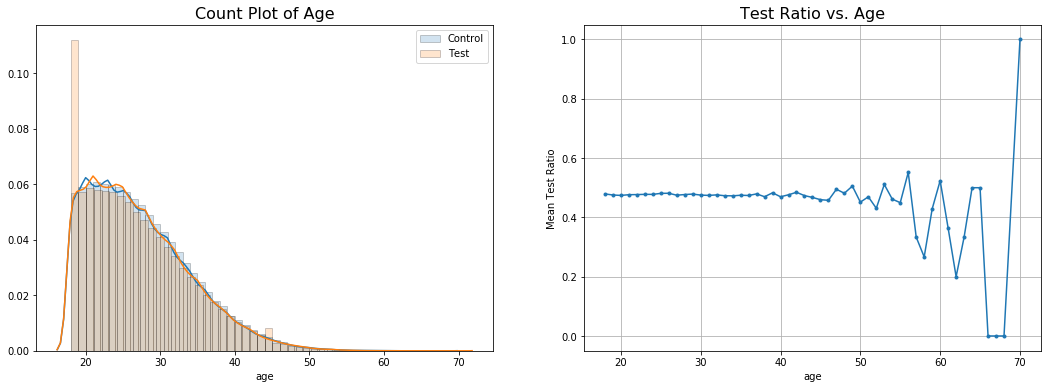

In [237]:
# Visualization of different sources
grouped = total[['age', 'test']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(total[total['test'] == 0]['age'], label='Control', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(total[total['test'] == 1]['age'], label='Test', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['test'], '.-')
ax[1].set_title('Test Ratio vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean Test Ratio')
ax[1].grid(True)
plt.show()

- Generally the assignment across age looks fine - the dist plot mostly aligned with each other.
- However, there is a huge spike below age of 20 in test group and flunctuation of assignment ratio after age of 45
- Let's investigate:

Text(0.5, 1.0, 'Number of Users')

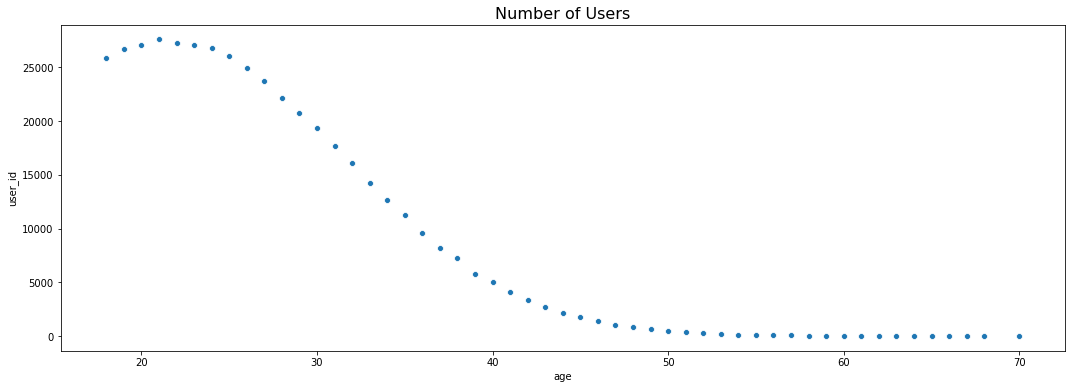

In [166]:
df_age = total[['age','user_id']].groupby('age').count().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.scatterplot(df_age['age'], df_age['user_id'])
ax.set_title('Number of Users', fontsize=16)

- Because the total number of people become a lot fewer after the age of 48, the fluntuation occurs. We may want to exclude people over the age of 48
- Even though there is a spike around 20 in test group, from the test ratio graph, it's not abnormal below 20

## Post-experiement

### 1. Confirm ATE Direction

In [247]:
y = total['conversion']
X = total['test']

In [255]:
import statsmodels.formula.api as sm
 
result1 = sm.ols('conversion ~ test', data=total).fit() 

In [256]:
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     331.0
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           6.09e-74
Time:                        17:17:51   Log-Likelihood:                 49421.
No. Observations:              452867   AIC:                        -9.884e+04
Df Residuals:                  452865   BIC:                        -9.882e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0552      0.000    123.788      0.0

- The direction is indeed negative

- The reason might be not valid random assignment for countries

### 2. Validity Investigation

- #### Control for Country

In [288]:
result2 = sm.ols('conversion ~ test+country', data=df[df['age']<48]).fit() 
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4620
Date:                Sun, 03 Nov 2019   Prob (F-statistic):              0.953
Time:                        17:46:01   Log-Likelihood:                 35339.
No. Observations:              347691   AIC:                        -7.065e+04
Df Residuals:                  347676   BIC:                        -7.049e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

- #### Drop Invalid Random Assignment

In [264]:
df = total[(total['country'] != 'Spain') & (total['country'] != 'Argentina') & (total['country'] != 'Uruguay') ]

In [280]:
result3 = sm.ols('conversion ~ test', data=df[df['age']<48]).fit() 
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.06243
Date:                Sun, 03 Nov 2019   Prob (F-statistic):              0.803
Time:                        17:36:10   Log-Likelihood:                 35336.
No. Observations:              347691   AIC:                        -7.067e+04
Df Residuals:                  347689   BIC:                        -7.065e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0502      0.001     95.904      0.0

- If we control for country, the ATE is not significant
- After excluding those imbalanced assignment, we cannot reject the null hypothesis that the change is significant.
- The reason that the effect appears to be negative because of invalid random assignment across countries

### 3. Data Quanlity Check Design

In [282]:
def randomization_valid(data,target,assignment_name, balance_ratio, ID):
    variables = data.drop(columns=[target, ID])
    columns = variables.drop(columns=[assignment_name]).columns
    for col in columns:
        check = data.groupby([col])[assignment_name].mean()
        for ratio in check:
            if ratio > balance_ratio:
                #print(check.head())
                return False
    return True
        

In [285]:
randomization_valid(total[total['age'] < 48],'conversion','test', 0.5, 'user_id')

False

- Pass the dataset, the name of the target, the name of the assignment column, the ID column, and the ratio that's consider balance to the function